In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
SEED = 13
tf.random.set_seed(SEED)

In [ ]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [ ]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


Mounted at /content/drive


In [ ]:
file_name = ['SKS_2_I_r.xlsx',  'SKS_3_I_r.xlsx',  'SKS_4_I_r.xlsx','SKS_5_I_r.xlsx', 'SD_2_I_r.xlsx',  'SD_3_I_r.xlsx',  'SD_4_I_r.xlsx','SD_5_I_r.xlsx', 'SD_1_I_r.xlsx']
# file_name = ['PK_0_I.xlsx', 'PK_2_I.xlsx', 'PK_3_I.xlsx','PK_5_2_I.xlsx']
# file_name = ['TH_4_I_r.xlsx', 'TH_3_I_r.xlsx', 'TH_2_I_r.xlsx']
# file_name = ['SD_1_I_r.xlsx', 'SD_2_I_r.xlsx', 'SD_3_I_r.xlsx','SD_5_I_r.xlsx','SD_4_I_r.xlsx']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(path+ file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453260 entries, 0 to 453259
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      453260 non-null  float64
 1   l_ph_ank      453260 non-null  float64
 2   l_ph_fo       453260 non-null  float64
 3   r_ph_hip      453260 non-null  float64
 4   r_ph_ank      453260 non-null  float64
 5   r_ph_fo       453260 non-null  float64
 6   n_lgrf        453260 non-null  float64
 7   n_r_grf       453260 non-null  float64
 8   n_lcop        453260 non-null  float64
 9   n_rcop        453260 non-null  float64
 10  strike_frame  453260 non-null  int64  
 11  perc          453260 non-null  float64
 12  st_sw_phase   453260 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 45.0 MB


In [ ]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,strike_frame,perc,st_sw_phase
0,0.579422,0.728283,0.824722,0.944556,0.852798,0.715394,0.788678,0.053675,-1.710029e-183,0.000855,1,0.000000,1
1,0.541914,0.728681,0.807850,0.943407,0.838606,0.714381,0.783316,0.071134,-2.318295e-183,0.001294,2,0.469484,1
2,0.496123,0.728944,0.796217,0.942094,0.827949,0.712877,0.775870,0.090660,-3.013682e-183,0.001805,3,0.938967,1
3,0.448026,0.729086,0.787733,0.940585,0.819759,0.710862,0.766080,0.112038,-3.798608e-183,0.002394,4,1.408451,1
4,0.405438,0.729114,0.781253,0.938852,0.813342,0.708286,0.753742,0.135157,-4.673614e-183,0.003066,5,1.877934,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451157,0.710613,0.751746,0.943747,0.017290,0.093317,0.724869,0.871078,0.000000,1.658447e-01,0.000993,183,96.808511,0
451158,0.706361,0.750410,0.904541,0.011437,0.061550,0.723751,0.880184,0.000000,1.672138e-01,0.001890,184,97.340426,0
451159,0.701397,0.749231,0.873076,0.005522,0.025155,0.722450,0.887812,0.000000,1.684189e-01,0.002960,185,97.872340,0
451160,0.695483,0.748165,0.849081,0.999552,0.987367,0.720930,0.893622,0.000000,1.694487e-01,0.004216,186,98.404255,0


In [ ]:
source_table = source_table.drop(["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank",], axis = 1)
source_table

,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,n_lcop,n_rcop,strike_frame,perc,st_sw_phase
0,0.579422,0.824722,0.944556,0.715394,-1.710029e-183,0.000855,1,0.000000,1
1,0.541914,0.807850,0.943407,0.714381,-2.318295e-183,0.001294,2,0.469484,1
2,0.496123,0.796217,0.942094,0.712877,-3.013682e-183,0.001805,3,0.938967,1
3,0.448026,0.787733,0.940585,0.710862,-3.798608e-183,0.002394,4,1.408451,1
4,0.405438,0.781253,0.938852,0.708286,-4.673614e-183,0.003066,5,1.877934,1
...,...,...,...,...,...,...,...,...,...
451157,0.710613,0.943747,0.017290,0.724869,1.658447e-01,0.000993,183,96.808511,0
451158,0.706361,0.904541,0.011437,0.723751,1.672138e-01,0.001890,184,97.340426,0
451159,0.701397,0.873076,0.005522,0.722450,1.684189e-01,0.002960,185,97.872340,0
451160,0.695483,0.849081,0.999552,0.720930,1.694487e-01,0.004216,186,98.404255,0


In [ ]:
x = source_table
x = x.drop(['perc'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [ ]:
data_y = y.values.reshape(-1,2)

In [ ]:
type(data_y)

numpy.ndarray

In [ ]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(338360, 10, 8)
(338360, 2)
(112780, 10, 8)
(112780, 2)


In [ ]:
train_x.shape

(338360, 10, 8)

In [ ]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(11277, 10, 8)
(11277, 2)


In [ ]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:

lr = 0.001
epochs = 30
batch = 128
x=Input(shape=(10, 8))
n_features=train_x.shape[2]
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer1 = LSTM(64, return_sequences=True)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(LSTM_layer1)
attn_layer1 = attention()(LSTM_layer2)
rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            18688     
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            12416     
                                                                 
 attention (attention)       (None, 32)                42        
                                                                 
 repeat_vector (RepeatVector  (None, 10, 32)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                             

In [ ]:
model_history = model.fit( train_x, train_x, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
2644/2644 [==============================] - 160s 58ms/step - loss: 0.0083
Epoch 2/30
2644/2644 [==============================] - 151s 57ms/step - loss: 0.0021
Epoch 3/30
2644/2644 [==============================] - 147s 56ms/step - loss: 0.0013
Epoch 4/30
2644/2644 [==============================] - 160s 60ms/step - loss: 8.5543e-04
Epoch 5/30
2644/2644 [==============================] - 160s 60ms/step - loss: 6.2963e-04
Epoch 6/30
2644/2644 [==============================] - 158s 60ms/step - loss: 5.0517e-04
Epoch 7/30
2644/2644 [==============================] - 158s 60ms/step - loss: 4.0434e-04
Epoch 8/30
2644/2644 [==============================] - 157s 59ms/step - loss: 3.5278e-04
Epoch 9/30
2644/2644 [==============================] - 155s 59ms/step - loss: 3.0396e-04
Epoch 10/30
2644/2644 [==============================] - 158s 60ms/step - loss: 2.5440e-04
Epoch 11/30
2644/2644 [==============================] - 158s 60ms/step - loss: 2.3416e-04
Epoch 12/30
2644/264

In [ ]:
encoder = Model(inputs=model.inputs, outputs=model.layers[3].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

3525/3525 [==============================] - 17s 5ms/step
Encoded time-series shape (338360, 32)
Encoded time-series sample [ 0.03778386 -0.08659124  0.40724856  0.1310493   0.0897869  -0.08243144
 -0.34362406 -0.1901399   0.34798652  0.20975555  0.19498149 -0.80279136
  0.79430115 -0.0760392  -0.1328722  -0.11329944 -0.06282281  0.2380487
 -0.0429531   0.3736136   0.8465691  -0.4091735  -0.11909579  0.01682688
  0.36291593  0.15447453  0.23312548  0.0012039   0.26068625 -0.12709773
  0.35872537  0.27647293]


In [ ]:
model.save(path+"autoen_new_model_sd_sks")

In [ ]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [ ]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,338
Trainable params: 1,338
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
train_encoded_reshaped = train_encoded
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
2644/2644 - 5s - loss: 0.0197 - 5s/epoch - 2ms/step
Epoch 2/50
2644/2644 - 4s - loss: 0.0036 - 4s/epoch - 2ms/step
Epoch 3/50
2644/2644 - 4s - loss: 0.0032 - 4s/epoch - 2ms/step
Epoch 4/50
2644/2644 - 5s - loss: 0.0030 - 5s/epoch - 2ms/step
Epoch 5/50
2644/2644 - 4s - loss: 0.0029 - 4s/epoch - 1ms/step
Epoch 6/50
2644/2644 - 4s - loss: 0.0028 - 4s/epoch - 1ms/step
Epoch 7/50
2644/2644 - 5s - loss: 0.0028 - 5s/epoch - 2ms/step
Epoch 8/50
2644/2644 - 4s - loss: 0.0027 - 4s/epoch - 2ms/step
Epoch 9/50
2644/2644 - 4s - loss: 0.0027 - 4s/epoch - 1ms/step
Epoch 10/50
2644/2644 - 4s - loss: 0.0026 - 4s/epoch - 2ms/step
Epoch 11/50
2644/2644 - 6s - loss: 0.0026 - 6s/epoch - 2ms/step
Epoch 12/50
2644/2644 - 4s - loss: 0.0026 - 4s/epoch - 2ms/step
Epoch 13/50
2644/2644 - 4s - loss: 0.0026 - 4s/epoch - 2ms/step
Epoch 14/50
2644/2644 - 5s - loss: 0.0025 - 5s/epoch - 2ms/step
Epoch 15/50
2644/2644 - 5s - loss: 0.0025 - 5s/epoch - 2ms/step
Epoch 16/50
2644/2644 - 4s - loss: 0.0025 - 4s/ep

In [ ]:
val_encoded_reshaped = validation_encoded
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

3525/3525 [==============================] - 7s 2ms/step


In [ ]:
testPredict.shape

(112780, 2)

In [ ]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.05 RMSE


In [ ]:
v = X_test[11:]
v.shape

(112780, 8)

In [ ]:

x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


  # if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) :
  #   pred[iter] = pred[iter] - 100
  #   if abs(pred[iter]) >= 5:
  #     pred[iter] = 0


  # if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
  #   pred[iter] = 100 - pred[iter]
  #   if abs(pred[iter]) >= 5:
  #       pred[iter] = 100




  # if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [ ]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [ ]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

78759
112780
Precision  1 :  69.8341904593013
105113
112780
Precision  2 :  93.20180883135308
111451
112780
Precision  3 :  98.82159957439262
112470
112780
Precision  4 :  99.7251285688952
112685
112780
Precision  5 :  99.91576520659692


In [ ]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)
rmse = 0
length = len(actual)
for i in range(len(actual)):

    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

Predicting Percentage RMSE:  8.89868425439125
112780
112780
8.898684254391249


<ipython-input-41-25c0a31c81dc>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmse = math.sqrt(rmse)


79876
112780


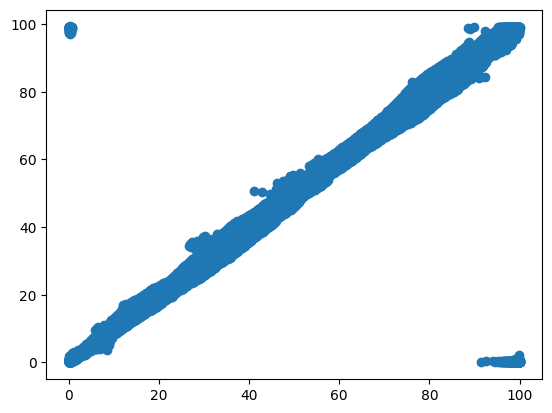

In [ ]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<5 or actual[iter]>95:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

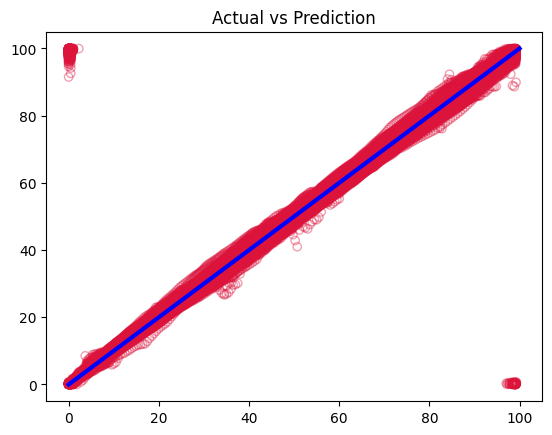

In [ ]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

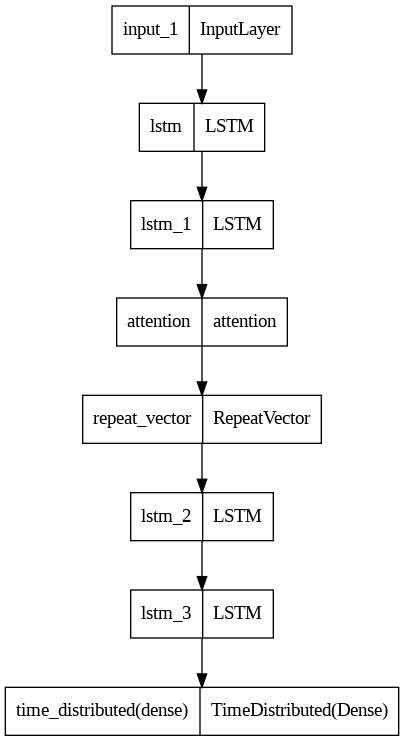

In [ ]:
tf.keras.utils.plot_model(model, 'model_new.png')

In [ ]:
mlp_model.save(path+"mlp_new_model_sd_sks")